In [ ]:
pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.9 MB/s eta 0:00:00


In [1]:
import os
import chess
import numpy as np
import pandas as pd
import keras
import time

from keras import callbacks, optimizers
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
from IPython.display import clear_output
from matplotlib import pyplot as plt

C:\Users\kylia\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def make_matrix(board):
    pgn = board.epd()
    foo = []
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo

def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

def data_setup():
    X = []
    y = []
    for game in range(len(data)):
        data[game] = data[game].split()
        board = chess.Board()
        for move in range(len(data[game])):
            # Remove parenthesis to fix issue with first move in game
            legal_moves = str(board.legal_moves)[36:-2].replace(',','').replace('(', '').split()
            matrix = make_matrix(board.copy())
            translated = translate(matrix,chess_dict)

            # Reshape the translated matrix to match the expected input shape
            reshaped_matrix = np.array(translated).reshape(8, 8, 12)

            X.append(reshaped_matrix)
            board.push_san(data[game][move])
            y.append(legal_moves.index(data[game][move]) / len(legal_moves))
    return X,y

def initialize_network():
    model = Sequential()
    model.add(Conv2D(filters=10, kernel_size=1, activation='relu', input_shape=(8,8,12)))
    model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Conv2D(filters=10, kernel_size=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Conv2D(filters=10, kernel_size=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=None))
    model.add(Conv2D(filters=10, kernel_size=1, activation='relu'))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(1,activation = 'sigmoid'))
    return model

board = chess.Board()
print(board.epd)

<bound method Board.epd of Board('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1')>


Preparing Data...
[[[0 0 0 1 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0

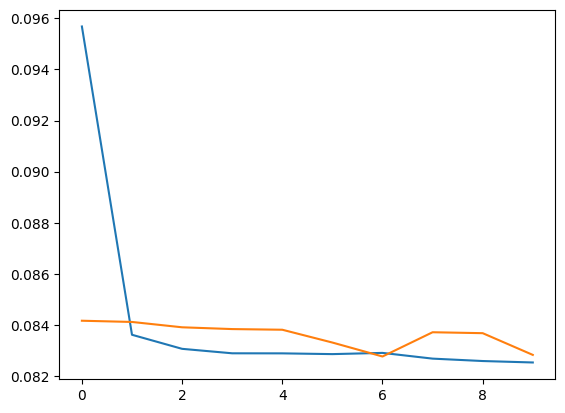

In [6]:
flatten = lambda l: [item for sublist in l for item in sublist]
df = pd.read_csv('chess_normalized.csv')
data = df['moves'].tolist()

lendata= len(data)
data = data[:100]

chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}

print('Preparing Data...')
start = time.time()
X,y = data_setup()
one_game_time = time.time()-start
X = np.array(X)
y = np.array(y)
print(X[0])
X_test = X[:int(len(X)*0.1)]
X_train = X[int(len(X)*0.1):]
y_test = y[:int(len(X)*0.1)]
y_train = y[int(len(X)*0.1):]
print('Initalizing Network...')
model = initialize_network()
print('Compiling Network...')

model.compile(optimizer='Nadam', loss='mse')
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='val_loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           save_freq=1)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
#history = model.fit(X_train,y_train,epochs = 10,verbose = 2,validation_data = (X_test,y_test),callbacks = callback)
history = model.fit(X_train,y_train,epochs = 10,verbose = 2,validation_data = (X_test,y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [14]:
model.save("./models/chessai.keras")

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load your Keras model
keras_model = model

# Convert the Keras model to a TensorFlow function
@tf.function
def serving_function():
    outputs = keras_model(np.expand_dims(X[0], 0))  # Replace input_data with an example input
    return {"output": outputs}

# Wrap the function in a SavedModel
tf.saved_model.save(
    keras_model,
    export_dir='./',
    signatures={'serving_default': serving_function}
)


INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


1/1 [==============================] - 0s 32ms/step


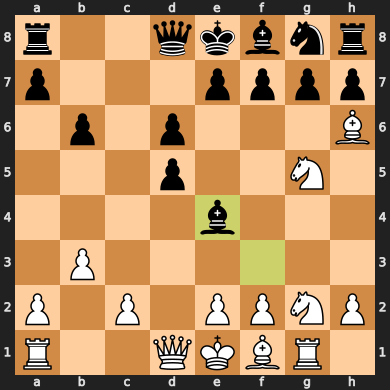

In [24]:
chess_board = chess.Board()
for i in range(100):
    matrix = make_matrix(chess_board)
    board = translate(matrix,chess_dict)
    board = np.array(board)
    board = np.reshape(board,(1,8,8,12))
    pred = model.predict(board)
    legal_moves = str(chess_board.legal_moves)[36:-2].replace(',','').split()
    index = int(round((len(legal_moves)*pred)[0][0]))
    chess_board.push_san(legal_moves[index])
    if chess_board.is_checkmate():
        break
chess_board

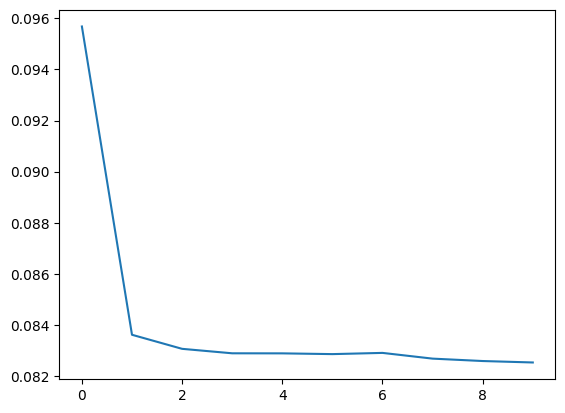

In [10]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])

In [ ]:
data = df['moves'].tolist()
data.index(sorted(data,key=lambda point: len(point),reverse = True)[0])

11554

In [11]:
model.weights

[<tf.Variable 'conv2d/kernel:0' shape=(1, 1, 12, 10) dtype=float32, numpy=
 array([[[[-0.47784126, -0.17043605,  0.49262556,  0.19656388,
           -0.34953043, -0.2869203 , -0.45121467, -0.37644452,
            0.42764008, -0.11650851],
          [-0.37582332, -0.28065246,  0.21034835, -0.11985111,
            0.5160538 , -0.46257174, -0.17529854,  0.48457834,
           -0.11674908,  0.20488262],
          [ 0.54891354,  0.2015014 ,  0.4352103 ,  0.3843428 ,
            0.4438036 ,  0.36129358, -0.12003228, -0.4391592 ,
           -0.35812598, -0.34239662],
          [-0.11015067,  0.30105886, -0.17215404,  0.5509222 ,
            0.47546366, -0.35387906,  0.31086862, -0.4106834 ,
           -0.20630914, -0.25931147],
          [ 0.16027483, -0.3150008 , -0.07783869, -0.10485202,
            0.17443311,  0.48422554,  0.24019368, -0.33423474,
            0.24853308,  0.44397742],
          [ 0.45975608, -0.45904648, -0.27444118,  0.03026114,
           -0.00514913,  0.3525901 , -0.50

In [12]:
X[1]

array([[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 

In [ ]:
import chess
board = chess.Board()
def make_matrix(board):
    pgn = board.epd()
    foo = []
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo

In [ ]:
import os
os.getcwd()
os.chdir('C:\\Users\\v_sim\\Desktop\\Files\\Data')

FileNotFoundError: ignored

In [ ]:
import chess.pgn
pgn = open("Carlsen.pgn")
sides = []
games = []
length = 100
for i in range(length):
    try:
        if chess.pgn.read_game(pgn).mainline_moves():
            games.append(chess.pgn.read_game(pgn).mainline_moves())
            sides.append(chess.pgn.read_game(pgn).headers["White"])
    except:
        print(i,chess.pgn.read_game(pgn))
        pass
len(games)

100

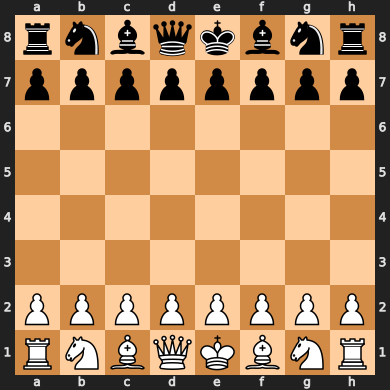

In [ ]:
X = []
y = []
counter2 = 0
for game in games:
    board = chess.Board()
    white = sides[counter2]
    if white == 'Carlsen,Magnus':
        remainder = 0
    else:
        remainder = 1
    counter = 0
    for move in game:
        if counter % 2 == remainder:
            X.append(board.copy())
        board.push(move)
        if counter % 2 == remainder:
            y.append(board.copy())
        counter += 1
    counter2 += 1
X[0]

In [ ]:
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1,0],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0,1],
}

def make_matrix(board):
    pgn = board.epd()
    foo = []
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo

def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

In [ ]:
import numpy as np
for i in range(len(X)):
    X[i] = translate(make_matrix(X[i]),chess_dict)
for i in range(len(y)):
    y[i] = translate(make_matrix(y[i]),chess_dict)
X = np.array(X)
y = np.array(y)

NameError: ignored

In [ ]:
import random
flatten = lambda l: [item for sublist in l for item in sublist]
def retranslate(action):
    board = []
    flatten_action = flatten(action)
    for i in range(len(flatten_action)):
        new_set = np.zeros((13,))
        max_index = list(flatten_action[i]).index(max(flatten_action[i]))
        new_set[max_index] = 1
        board.append(new_set)
    for i in range(len(board)):
        board[i] = new_chess_dict[tuple(board[i])]
    board = np.array(board).reshape(8,8)
    return board

def matrix2board(matrix):
    fen = []
    for row in matrix:
        foo2 = str()
        counter = 0
        counter2 = 0
        for thing in row:
            counter2+=1
            if thing == '.':
                counter+=1
            if counter2 == len(row) and thing == '.':
                foo2+=str(counter)
            if thing != '.':
                if counter > 0:
                    foo2+=str(counter)
                    counter = 0
                foo2+=thing
        fen.append(foo2)

    final_fentasy = str()
    for i in range(len(fen)):
        final_fentasy += fen[i]
        if i != len(fen)-1:
            final_fentasy += '/'
    return chess.Board(final_fentasy)

new_chess_dict = {}
for term in chess_dict:
    definition = tuple(chess_dict[term])
    new_chess_dict[definition] = term
    new_chess_dict[term] = definition

matrix = retranslate(random.choice(X))
board = matrix2board(matrix)
board

NameError: ignored